**Notebook Title:** 2D Single Grid Dynamics (Guanella et al., 2007)

**Date Logged:** 2026-01-06
inputs.

**Reference:**   
Guanella, D., Kiper, D. C., & Verschure, P. F. M. J. (2007). A model of grid cells based on a twisted torus topology. Hippocampus, 17(11), 1001-1014.  
Zilli EA. Models of grid cell spatial firing published 2005-2011. Front Neural Circuits. 2012 Apr 18;6:16. doi: 10.3389/fncir.2012.00016. PMID: 22529780; PMCID: PMC3328924.  
**Original Matlab code** : https://github.com/ModelDBRepository/144006

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import os
from tqdm import tqdm
import scipy.io as sio
from scipy.interpolate import interp1d
import time 
from datetime import datetime
import matplotlib.animation as animation

### 1. Prepare Trajectories
+ 可以直接使用实验数据

In [3]:
# Load trajectory data
f_p_data= r'...\\data'
f_name = 'HaftingTraj_centimeters_seconds.mat'
traj_data = sio.loadmat(os.path.join(f_p_data, 'HaftingTraj_centimeters_seconds.mat'))
pos = traj_data['pos']   # pos.shape = (3, 29416)

In [4]:
# 轨迹数据处理和速度计算修复
# 关键问题修复：时间单位统一 + 插值步长合理

# 1. 检查原始数据并计算采样间隔
print(f"Original pos shape: {pos.shape}")
tmin = pos[2, 0]
tmax = pos[2, -1]
print(f"Original time range (seconds): {tmin:.3f} to {tmax:.3f}")

# 2. 计算原始采样间隔
dt_original = np.mean(np.diff(pos[2, :]))  # 秒
print(f"Original sampling interval: {dt_original:.6f} s ({1/dt_original:.2f} Hz)")


Original pos shape: (3, 29416)
Original time range (seconds): 0.000 to 591.040
Original sampling interval: 0.020093 s (49.77 Hz)


In [5]:

# 3. 定义合理的插值步长（必须与 dt_sim 一致！）
dt = 20  # 0.02 秒 = 20 ms（与模拟步长保持一致）

# 4. 创建均匀的时间网格（包括末尾！）
time_points = np.arange(0, tmax*1e3 + dt, dt)
print(f"Interpolated time points: {len(time_points)}")

# 5. 时间序列插值 （从时间t到轨迹位置x和y）
f_x = interp1d(pos[2, :]*1e3, pos[0, :], kind='linear', bounds_error=False, fill_value='extrapolate')
f_y = interp1d(pos[2, :]*1e3, pos[1, :], kind='linear', bounds_error=False, fill_value='extrapolate')

pos_interp = np.vstack([
    f_x(time_points),
    f_y(time_points),
    time_points
])

# 7. 长度单位转换：厘米 → 米
pos_interp[0:2, :] = pos_interp[0:2, :] / 100
print(f"Position range (m): x=[{pos_interp[0, :].min():.3f}, {pos_interp[0, :].max():.3f}], y=[{pos_interp[1, :].min():.3f}, {pos_interp[1, :].max():.3f}]")

Interpolated time points: 29553
Position range (m): x=[-0.807, 0.858], y=[-0.898, 0.838]


In [6]:

# 8. 速度计算：使用正确的时间步长
vels = np.vstack([
    np.diff(pos[0, :]) / dt,  # m/s
    np.diff(pos[1, :]) / dt   # m/s
])

# 重要：补充末尾速度（使用最后一个速度向量）
last_vel = vels[:, [-1]]  # 复制最后一列
vels = np.hstack([vels, last_vel])

print(f"Velocity shape: {vels.shape}")
print(f"Position shape: {pos.shape}")
print(f"Shape match: {vels.shape[1] == pos.shape[1]}")
print(f"Velocity range (m/s): [{np.min(vels):.6f}, {np.max(vels):.6f}]")
print(f"Mean velocity magnitude: {np.mean(np.linalg.norm(vels, axis=0)):.6f} m/s")


Velocity shape: (2, 29416)
Position shape: (3, 29416)
Shape match: True
Velocity range (m/s): [-0.088648, 0.082478]
Mean velocity magnitude: 0.022205 m/s


### 2. Parameters

In [7]:
# Grid 网络参数（单个模块）
Nx = 15
Ny = 12   # 神经元排列（Nx ≈ 2/sqrt(3) * Ny）
ncells = Nx * Ny  # 单个模块的细胞数
alpha = 0.5   # 输入增益
beta = 0     # 输入方向偏差（网格朝向）
sigma = 0.24  # 指数权重的标准差
I = 0.3       # 峰值突触强度（激发中心）
T = 0.05      # 阈值偏移（使权重的尾部抑制性）
tau = 0.8     # 归一化 vs 全强度突触输入的相对权重
# time unit ms
dt = 20 # 模拟时间步，秒（= 20 ms，与原 MATLAB dt=20ms 对应）

# rotation matrix for directional input 可以直接改变grid orientation
R = np.array([[np.cos(beta), -np.sin(beta)],
                  [np.sin(beta), np.cos(beta)]])

#### Neural Sheet and Weight

In [8]:
# Arrange cells on 2D neural sheet
x = ((np.arange(1,Nx+1,1)-0.5)/Nx)
y = (np.sqrt(3)/2) * ((np.arange(1,Ny+1,1) - 0.5) / Ny)

X, Y = np.meshgrid(x,y)
X_flat = X.T.flatten()   # x_coord of each cell
Y_flat = Y.T.flatten()   # y_coord of each cell
# create 2xncells position matrix
x = np.vstack([X_flat, Y_flat])
print(x.shape)

# 创建jx, ix, jy, iy以计算所有细胞对之间距离
# x.shape = (2, ncells)
jx_grid, ix_grid = np.meshgrid(x[0,:], x[0,:])   # x_coor x x_coor of all cells
# 注意：flatten 和 reshape 的顺序必须一致！
# MATLAB 默认列优先(column-major)，所以这里也用列优先
jy_grid, iy_grid = np.meshgrid(x[1, :], x[1, :])  # y_coor x y_coor of all cells
jx = jx_grid.flatten(order='F').reshape(1,-1)  # MATLAB按列优先展平
ix = ix_grid.flatten(order='F').reshape(1,-1)
jy = jy_grid.flatten(order='F').reshape(1,-1)
iy = iy_grid.flatten(order='F').reshape(1,-1)

(2, 180)


网格细胞序列坐标是一致的，但是Y坐标可能有误差

In [9]:

def weight_matrix(v, ncells, ix, jx, iy, jy, alpha, sigma, I, T):
    '''
    计算权重矩阵 Warning
    源代码中缺少 dt 参数
    '''
    W_matrix = np.zeros((ncells, ncells))
    offsets = [
            (0, 0),                    # 0: 无偏移
            (-0.5, np.sqrt(3)/2),      # 1: 
            (-0.5, -np.sqrt(3)/2),     # 2:
            (0.5, np.sqrt(3)/2),       # 3:
            (0.5, -np.sqrt(3)/2),      # 4:
            (-1, 0),                   # 5:
            (1, 0)                     # 6:
        ]

    # 初始化最小距离数组
    min_square_dists = np.inf * np.ones_like(ix)
    # 对所有偏移量计算距离，找出最小距离
    for dx, dy in offsets:
        dx_term = ix - jx + dx + alpha * v[0]
        dy_term = iy - jy + dy + alpha * v[1]
        square_dists = dx_term**2 + dy_term**2
        min_square_dists = np.minimum(min_square_dists, square_dists)
    # 关键修复：reshape 必须使用 order='F' 与 flatten(order='F') 匹配
    square_pairwise_dists = min_square_dists.reshape((ncells, ncells), order='F').T   # shape=(ncells*ncells)神经元自连接距离矩阵
    W_matrix = I * np.exp(-square_pairwise_dists / sigma**2) - T
    # print('W')
    return W_matrix

### 3. Simulation

In [10]:

# for i in range(100000):
dt = 20
simdur = int(100e3)  # simulation duration, should be less than len(traj)
n_steps = int(simdur/dt)
stabilizationTime = 100  # time to let the network stabilize before recording
useRealTrajectory = 1
constantVelocity = np.array([0.0020, 0.001])  # m/s
positions = np.zeros((2, n_steps+1))
Ahist = np.zeros(n_steps+1)
A_all_time = np.zeros((Ny, Nx, n_steps))
# squDist = []   # 储存每个时间步的距离矩阵
# A_max_all = []  # 储存每个时间步的最大活动值
# eigmax = [] # 储存每个时间步的最大特征值
# W_all = []
# B_all = []
A = np.random.rand(1, ncells) / np.sqrt(ncells)

tind = 0   # 循环次数
# biases = []
for t in range(0, simdur, dt):
    # t = tind * dt
    
    if t <  stabilizationTime:
        v = np.array([0.0, 0.0])
    else:
        if useRealTrajectory:
            v = vels[:, tind]
        else:   
            v = constantVelocity
    # 计算权重矩阵并更新神经元活动
    v = R @ np.array(v)   # rotate velocity vector
    W = weight_matrix(v, ncells, ix, jx, iy, jy, alpha, sigma, I, T)
    B = A@W.T
    sum_A = np.sum(A)
    A = (1 - tau) * B + tau * (B / sum_A)
    A[A<0]=0
    
    # 保存选择神经元活动
    Ahist[tind] = np.squeeze(A)[0]
    A_2d = A.reshape((Nx,Ny)).T
    A_all_time[:, :, tind] = A_2d
    if useRealTrajectory:
        positions[:, tind] = pos[0:2, tind]

    if t % 10000==0:
        # print(A.sum(), B.sum())
    tind  = tind + 1

4.5962094382212975 14.249255096234018
18.92334209843405 41.296431506546995
18.898237745421305 41.22433047284897
18.882493060400265 41.23985096071167
18.931535009708057 41.31958459202891
18.885192617717145 41.25235479332592
18.908160455066625 41.31490036297566
18.90577607762638 41.284344137358914
18.88268994437065 41.230916405512836
18.91208209015974 41.219204442035675


### 4. Animate Visualization

In [11]:
# create visualization folder_path
folder = 'visualization'
cur_dir = os.getcwd()
folder_path = os.path.join(cur_dir, folder)
print(folder_path)
if not os.path.exists(folder_path):
    print(f'文件夹{folder}生成')
    os.makedirs(folder_path)

d:\prob_learning\grid_cell\202601_Loop model\visualization


#### 1. Heatmap for population activity

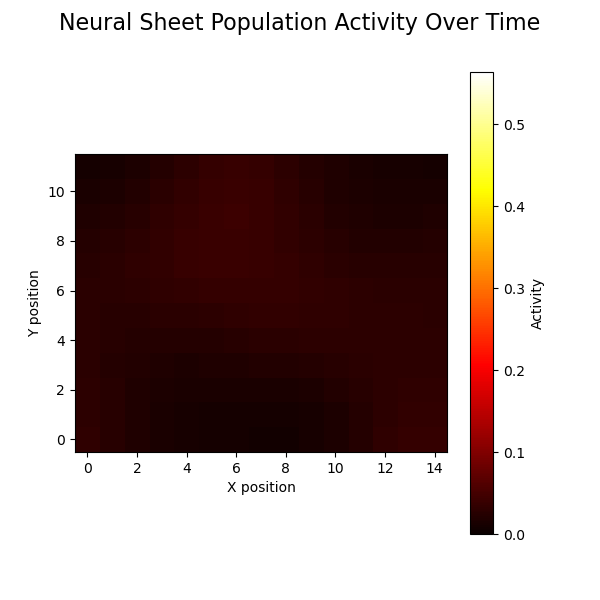

In [12]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.suptitle('Neural Sheet Population Activity Over Time', fontsize=16)
im = ax.imshow(
    A_all_time[:, :, 0],
    origin='lower',
    cmap='hot',
    vmin=0,
    vmax=np.max(A_all_time),
    animated=False
)
# ax.set_title('Population Activity (t = 0.00 s)')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
plt.colorbar(im, ax=ax, label='Activity')

# redefine update to only update the heatmap
def update2(frame):
    im.set_array(A_all_time[:, :, frame])
    im.set_clim(0, np.max(A_all_time))
    t_ms = frame * dt
    if useRealTrajectory:
        title = f'(t = {t_ms:.2f} ms)'
    else:
        title = f'(t = {t_ms:.2f} ms, v = [{constantVelocity[0]:.3f}, {constantVelocity[1]:.3f}] m/s)'
    ax.set_title(title)
    return (im,)

# create new animation (replace previous)
ani = animation.FuncAnimation(
    fig,
    update2,
    frames=min(n_steps, 500),
    interval=50,
    blit=False,
    repeat=True
)

plt.show()

In [13]:
ani.event_source.stop()
%matplotlib inline

save animation

In [ ]:
print("Saving animation...")
timestamp = datetime.now().strftime("%m%d_%H%M%S")
# ani.save('neural_sheet_activity'+timestamp+'.mp4', writer='ffmpeg', fps=20, dpi=100)
ani.save(os.path.join(folder_path, 'NxNy15-12'+timestamp+'.gif'), writer='pillow', fps=20, dpi=100)
print("Animation saved")


#### 2. Trajectories and Population Activity

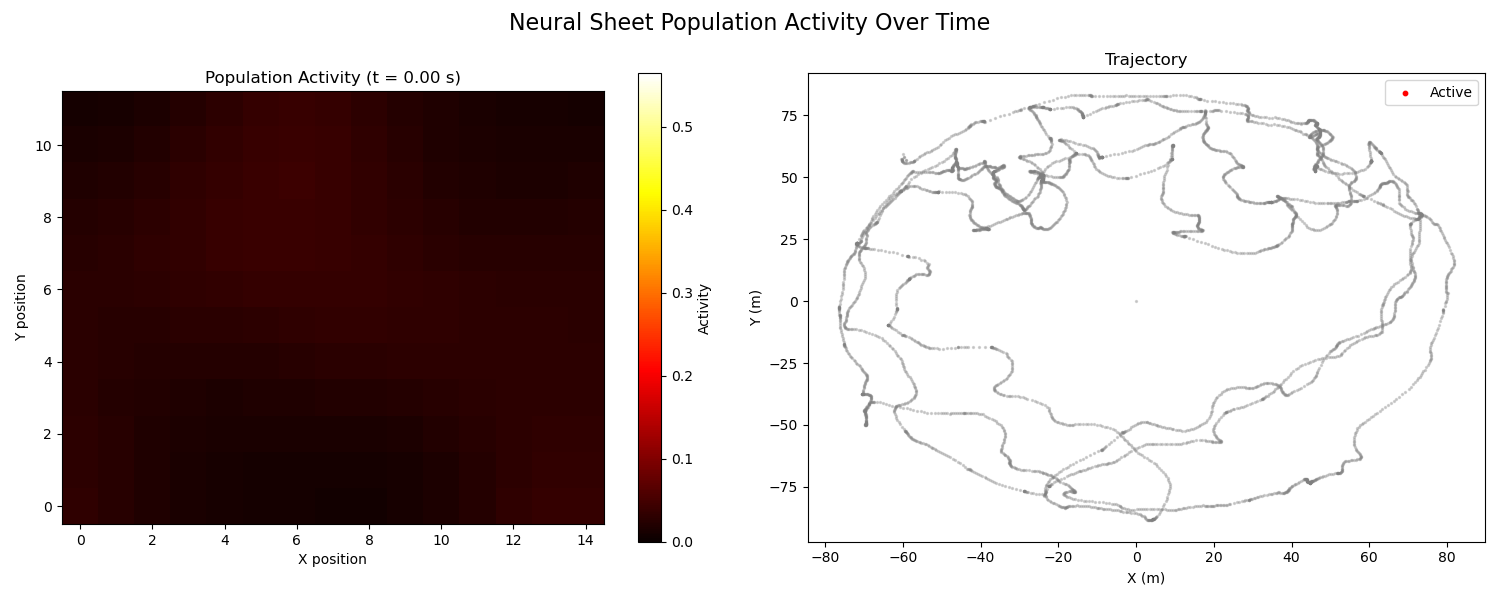

In [14]:
%matplotlib widget
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Neural Sheet Population Activity Over Time', fontsize=16)

# --- 左图：neural sheet population ---
ax1 = axes[0]
im = ax1.imshow(
    A_all_time[:, :, 0],
    origin='lower',
    cmap='hot',
    vmin=0,
    vmax=np.max(A_all_time),
    animated=False
)
ax1.set_title('Population Activity (t = 0.00 s)')
ax1.set_xlabel('X position')
ax1.set_ylabel('Y position')
plt.colorbar(im, ax=ax1, label='Activity')

# --- 右图：trajectory ---
ax2 = axes[1]
# 绘制完整轨迹
ax2.scatter(positions[0, :], positions[1, :],
            color='grey', alpha=0.3, s=2)

scatter1 = ax2.scatter([], [], color='red', s=10, label='Active')
ax2.set_title('Trajectory')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.legend()

plt.tight_layout()



def update(frame):
    # 更新神经元活动热图
    # 预计算 vmax（避免每帧扫数组）
    vmax = np.max(A_all_time[:,:,frame])
    im.set_array(A_all_time[:, :, frame])
    im.set_clim(0, vmax)
    
    # 使用一致的时间定义（秒）
    t_sec = frame * dt
    ax1.set_title(f'Population Activity (t = {t_sec:.2f} ms)')

    # 获取数据段
    pos_seg = positions[:, :frame]
    Ahist_seg = Ahist[:frame]

    # 关键修复：检查有效的位置数据
    # 只选择有有效活动且位置不是 NaN 的点
    active_mask = Ahist_seg > 0  # 神经活动有效
    active_seg = pos_seg[:, active_mask]
    if len(active_seg[0]) > 0:
        scatter1.set_offsets(np.column_stack([active_seg[0], active_seg[1]]))
    else:
        scatter1.set_offsets(np.empty((0,2)))

    return im, scatter1

ani = animation.FuncAnimation(
    fig,
    update,
    frames=min(n_steps, 5000),
    interval=50,
    blit=False,
    repeat=True
)

plt.show()


In [15]:
ani.event_source.stop()
%matplotlib inline


In [32]:

print("Saving animation...")
timestamp = datetime.now().strftime("%m%d_%H%M%S")
# ani.save('neural_sheet_activity'+timestamp+'.mp4', writer='ffmpeg', fps=20, dpi=100)
ani.save(os.path.join(folder_path, 'neural_sheet_activity'+timestamp+'.gif'), writer='pillow', fps=20, dpi=100)
print("Animation saved")


Animation saved


In [ ]:

# Save animation as MP4
print("Saving animation as MP4...")
timestamp = datetime.now().strftime("%m%d_%H%M%S")
ani.save(os.path.join(folder_path, 'trajectory_activity'+timestamp+'.mp4'), writer='ffmpeg', fps=20, dpi=100)
print("Animation saved as MP4")